In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

In [4]:
n_process = 32

# load data

In [5]:
data_dir = 'data'

In [6]:
i_sim = 0

In [7]:
data_network = pd.read_feather('%s/network.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir,i_sim))

In [8]:
n_node = len(data_feature)
n_edge = len(data_network)

In [9]:
data_network

,row,col
0,1,2311
1,1,3144
2,1,3568
3,1,3603
4,2,2146
...,...,...
9917,3999,3227
9918,4000,279
9919,4000,2085
9920,4000,3306


In [10]:
data_feature

,X1,X2,X3,W1,W2,W3,p,T,m,Y
0,0,1,1,-0.25,0.25,-0.25,0.500000,1,0.622459,0
1,0,0,1,0.25,-0.25,-0.25,0.222700,1,0.904651,1
2,1,0,0,-0.25,0.25,-0.25,0.544525,0,0.320821,1
3,0,1,1,-0.25,0.25,-0.25,0.651355,1,0.407333,1
4,1,1,1,0.25,0.25,0.25,0.500000,1,0.622459,1
...,...,...,...,...,...,...,...,...,...,...
3995,0,1,0,-0.25,-0.25,0.25,0.500000,1,0.622459,0
3996,1,1,0,0.25,-0.25,-0.25,0.500000,0,0.377541,0
3997,0,1,0,-0.25,-0.25,0.25,0.222700,0,0.777300,1
3998,0,0,0,0.25,0.25,0.25,0.777300,1,0.222700,0


In [11]:
Adj = sparse.csr_matrix((
    np.full(n_edge, True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [12]:
G = KECENI.Graph(Adj)

In [13]:
Ys = data_feature.iloc[:,9].values
Ts = data_feature.iloc[:,7].values
Xs = data_feature.iloc[:,3:6].values

In [14]:
data = KECENI.Data(Ys, Ts, Xs, G)

# hyperparameters

In [15]:
from hyperparams import delta

# counterfactual of interest

In [16]:
i0s = np.arange(0,n_node,10)

In [17]:
T0s_0 = Ts.copy(); T0s_0[:] = 0
T0s_1 = Ts.copy(); T0s_1[:] = 1

In [18]:
T0s = np.stack([T0s_0, T0s_1], 0)

# groundtruth

In [19]:
from KECENI.RegressionModel import FittedRegressionModel
from KECENI.PropensityModel import FittedPropensityModel
from KECENI.CovariateModel import FittedCovariateModel

In [20]:
from true_model import mu, pi, rX

In [21]:
true_model = KECENI.Model(
    FittedRegressionModel(mu),
    FittedPropensityModel(pi),
    FittedCovariateModel(rX),
    delta
)

In [22]:
true_fit = true_model.fit(data, n_X=None)

In [23]:
result_true = true_fit.G_estimate(
    i0s[:,None], T0s, n_X=10000
)

In [24]:
YTRs_0, YTRs_1 = np.moveaxis(result_true, -1, 0)
YTRds = YTRs_1 - YTRs_0

In [25]:
EYTR_0 = np.mean(YTRs_0)
EYTR_1 = np.mean(YTRs_1)
EYTR_d = EYTR_1 - EYTR_0

In [26]:
EYTR_0, EYTR_1, EYTR_d

(0.405963835417983, 0.5938193578046029, 0.18785552238661996)

(array([ 58.,  25.,   0.,   0.,   4., 108.,  81.,  73.,  22.,  29.]),
 array([0.11562113, 0.12855088, 0.14148063, 0.15441039, 0.16734014,
        0.18026989, 0.19319965, 0.2061294 , 0.21905916, 0.23198891,
        0.24491866]),
 <BarContainer object of 10 artists>)

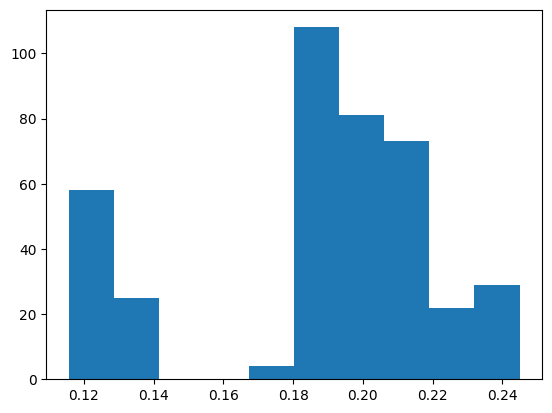

In [27]:
plt.hist(YTRds)

# estimation

In [28]:
from KECENI.RegressionModel import KernelRegressionModel
from KECENI.PropensityModel import KernelIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel

In [29]:
from hyperparams import delta_mu, delta_pi

## - cross-validation

### * outcome regression model

In [30]:
lamdas = np.linspace(0, 20, 21)[1:]

In [31]:
mu_fit = KernelRegressionModel(delta_mu).fit(data)

In [32]:
_, mus_cv = mu_fit.loo_cv(lamdas, tqdm=tqdm, n_process=n_process)

j: 100%|█████████████████████████████████████████████████████████| 4000/4000 [02:38<00:00, 25.22it/s]


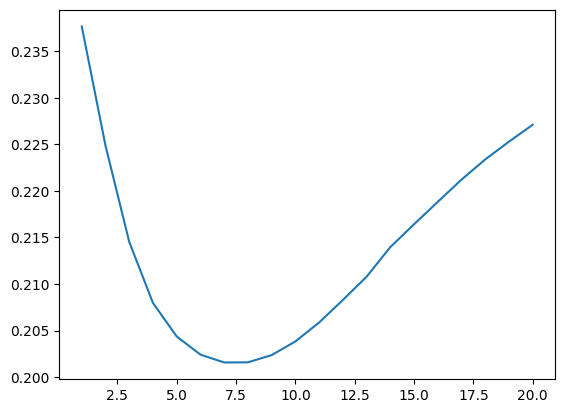

In [33]:
plt.plot(lamdas, np.mean((mus_cv-Ys)**2, -1))

In [34]:
id_mcv = np.argmin(np.mean((mus_cv-Ys)**2, -1))
lamda_mu = lamdas[id_mcv]

In [35]:
id_mcv, lamda_mu

(6, 7.0)

#### check

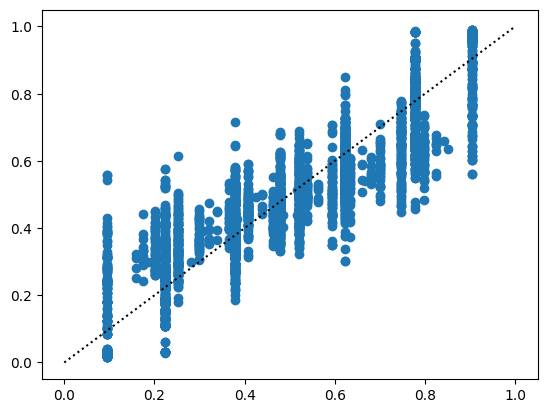

In [40]:
plt.scatter(data_feature.m.values, mus_cv[id_mcv])
plt.plot([0, 1], [0, 1], color='black', linestyle=':')

### * propensity score model

In [41]:
lamdas = np.linspace(0, 20, 21)[1:]

In [42]:
pi_fit = KernelIIDPropensityModel(delta_pi).fit(data)

In [43]:
_, pis_cv = pi_fit.loo_cv(lamdas, tqdm=tqdm, n_process=n_process)

j: 100%|█████████████████████████████████████████████████████████| 4000/4000 [02:28<00:00, 26.98it/s]


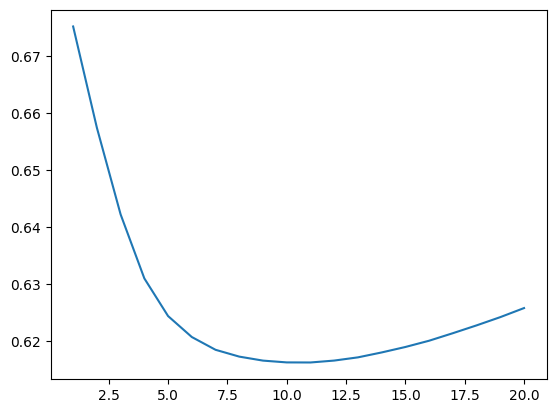

In [44]:
plt.plot(lamdas, np.mean(-np.log(np.abs(pis_cv + Ts - 1)), -1))

In [45]:
id_pcv = np.argmin(np.mean(-np.log(np.abs(pis_cv + Ts - 1)), -1))
lamda_pi = lamdas[id_pcv]

In [46]:
id_pcv, lamda_pi

(10, 11.0)

#### check

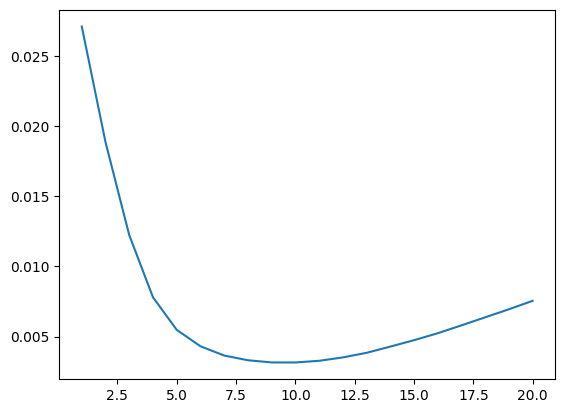

In [47]:
plt.plot(lamdas, np.mean((pis_cv - data_feature.p.values)**2, -1))

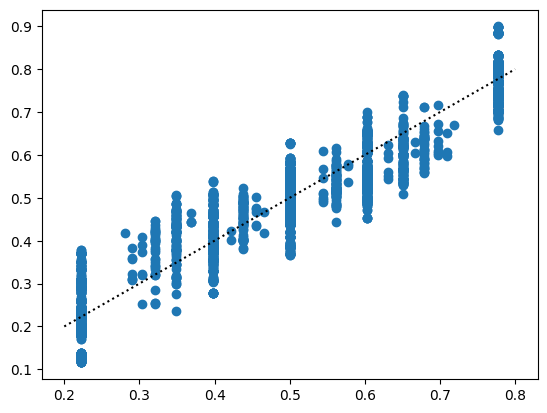

In [48]:
plt.scatter(data_feature.p.values, pis_cv[id_pcv])
plt.plot([0.2,0.8], [0.2,0.8], color='black', linestyle=':')

### * KECENI

In [49]:
# lamda_mu = 4.0
# lamda_pi = 5.0

In [50]:
keceni_model = KECENI.Model(
    KernelRegressionModel(delta_mu, lamda=lamda_mu),
    KernelIIDPropensityModel(delta_pi, lamda=lamda_pi),
    IIDCovariateModel(),
    delta
)

In [54]:
keceni_fit = keceni_model.fit(data, tqdm=tqdm)

fit: 100%|███████████████████████████████████████████████████████| 4000/4000 [08:58<00:00,  7.42it/s]


In [56]:
lamdas = np.linspace(0, 20, 21)[1:]

In [ ]:
result_cv = keceni_fit.cv(
    i0s=i0s, tqdm=tqdm
)

cv: 100%|████████████████████████████████████████████████████████| 4000/4000 [01:12<00:00, 55.06it/s]


In [61]:
xs_cv, xhs_cv = result_cv.xs_xhs(lamdas)

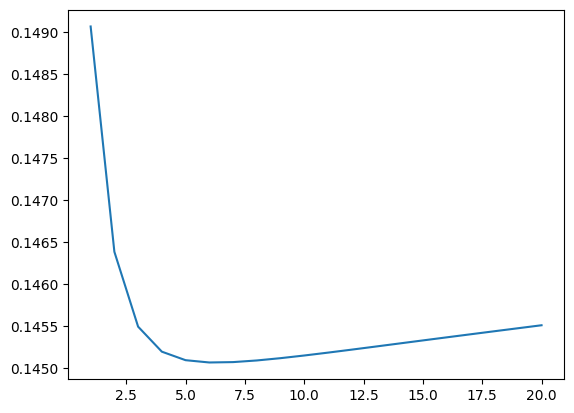

In [62]:
plt.plot(lamdas, np.mean((xs_cv-xhs_cv)**2, -1))

In [65]:
id_cv = np.argmin(np.mean((xs_cv-xhs_cv)**2, -1))
id_cv

5

In [ ]:
# id_cv = 5

In [67]:
lamdas[id_cv]

6.0

## - G estimate

In [ ]:
result_G = keceni_fit.G_estimate(
    i0s[:,None], T0s, n_X=1000,
    n_process=n_process, tqdm=tqdm, level_tqdm=0
)

i0: 100%|██████████████████████████████████████████████████████████| 800/800 [01:00<00:00, 13.26it/s]


In [69]:
YGs_0, YGs_1 = np.moveaxis(result_G, -1, 0)
YGs_d = YGs_1 - YGs_0

In [70]:
EYG_0 = np.mean(YGs_0)
EYG_1 = np.mean(YGs_1)
EYG_d = EYG_1 - EYG_0

In [ ]:
EYG_0, EYG_1, EYG_d

(0.5734096880417712, 0.4405732777999751, 0.13283641024179604)

(array([ 4., 16., 49., 92., 72., 49., 45., 27., 39.,  7.]),
 array([0.09054629, 0.09920658, 0.10786686, 0.11652715, 0.12518744,
        0.13384773, 0.14250802, 0.15116831, 0.1598286 , 0.16848889,
        0.17714918]),
 <BarContainer object of 10 artists>)

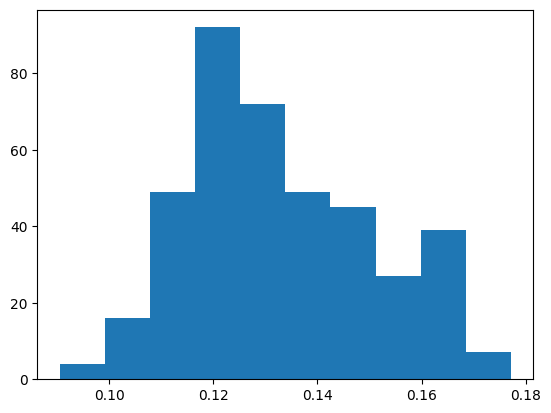

In [72]:
plt.hist(YGs_d)

## - DR estimate

In [ ]:
result_AIPW = keceni_fit.kernel_AIPW(
    i0s[:,None], T0s, tqdm=tqdm
)

AIPW: 100%|██████████████████████████████████████████████████████| 4000/4000 [01:24<00:00, 47.24it/s]


In [76]:
YDRs_0, YDRs_1 = np.moveaxis(result_AIPW.est(lamdas)[id_cv], -1, 0)
YDRs_d = YDRs_1 - YDRs_0

In [77]:
EYDR_0 = np.mean(YDRs_0)
EYDR_1 = np.mean(YDRs_1)
EYDR_d = EYDR_1 - EYDR_0

In [78]:
EYDR_0, EYDR_1, EYDR_d

(0.42239948450545034, 0.6051592247910856, 0.1827597402856353)

(array([ 29.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 371.]),
 array([0.17465303, 0.17552707, 0.17640111, 0.17727515, 0.17814918,
        0.17902322, 0.17989726, 0.1807713 , 0.18164534, 0.18251938,
        0.18339342]),
 <BarContainer object of 10 artists>)

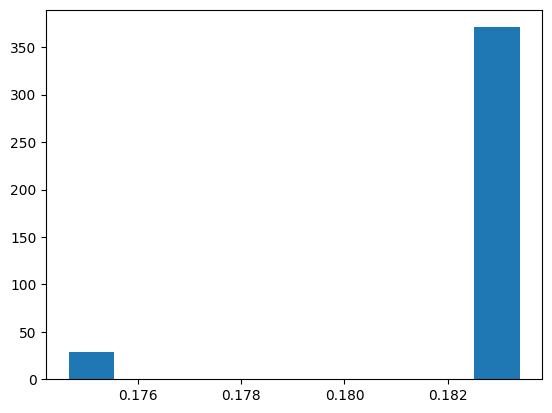

In [79]:
plt.hist(YDRs_d)